# DQNN Algorithm Tutorial

# Basic Imports

In [1]:
import gymnasium as gym
from tqdm.notebook import trange
import numpy as np
import torch
import matplotlib.pyplot as plt
import random

## The Environment — Process Model

In [2]:
def take_action(env, action):
    state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    return state, reward, done

In [3]:
def create_q_network(h1_size=50, h2_size=25):
    return torch.nn.Sequential(
        torch.nn.Linear(4, h1_size),
        torch.nn.ReLU(),
        torch.nn.Linear(h1_size, h2_size),
        torch.nn.ReLU(),
        torch.nn.Linear(h2_size, 2))

In [4]:
def compute_epsilon(epsilon_current, delta_epsilon, epsilon_min):
    epsilon_new = epsilon_current - delta_epsilon
    if epsilon_new < epsilon_min:
        epsilon_new = epsilon_min
    return epsilon_new

In [5]:
def choose_action(model, state, epsilon):
    q_values = model(torch.from_numpy(state).float())
    q_values_ = q_values.data.numpy()
    if random.random() < epsilon:
        action = np.random.randint(0, 2)
    else:
        action = np.argmax(q_values_)
    return action, q_values

In [6]:
def compute_loss(loss_function, model, experience, discounting_factor):
    state, action, reward, new_state, done = experience
    q_value = model(torch.from_numpy(state).float())
    with torch.no_grad():
        new_q_value = model(torch.from_numpy(new_state).float())

    max_q_value = torch.max(new_q_value)
    # target_ = reward + discounting_factor * max_q_value if not done else reward
    target_ = reward + discounting_factor * (1 - done) * max_q_value
    target = torch.Tensor([target_]).reshape(1)
    predict = q_value.squeeze()[action].reshape(1)
    return loss_function(predict, target.detach())

In [7]:
def create_loss_and_optimizer(model, learning_rate):
    loss_function = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    return loss_function, optimizer

In [8]:
def update_weights(optimizer, loss_value):
    optimizer.zero_grad()
    loss_value.backward()
    optimizer.step()

In [9]:
q_network = create_q_network()

env = gym.make("CartPole-v1")

In [10]:
gamma = 0.9
eps = 1.0

epochs = 1000
max_actions_per_game = 250

loss_fn, qnn_optimizer = create_loss_and_optimizer(q_network, 1e-3)
scores = []
for i in (pbar := trange(epochs)):

    s, _ = env.reset()

    actions_taken = 0
    total_loss = 0
    while True:
        actions_taken += 1
        a, q = choose_action(q_network, s, eps)
        new_s, r, terminate = take_action(env, a)

        terminate = terminate or \
                    (actions_taken == max_actions_per_game)

        exp = (s, a, r, new_s, terminate)
        loss = compute_loss(loss_fn, q_network, exp, gamma)
        update_weights(qnn_optimizer, loss)
        s = new_s

        total_loss += loss.item()
        if terminate:
            pbar.set_postfix_str(f"actions_taken={actions_taken}", refresh=False)
            scores.append(actions_taken)
            break

    eps = compute_epsilon(eps, delta_epsilon=1 / epochs, epsilon_min=0.1)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [11]:
def filter_timeseries(ts, p):
    tsf = np.nan * np.ones_like(ts)
    prev = ts[0]
    for i, v in enumerate(ts):
        tsf[i] = prev = p * prev + (1-p) * v
    return tsf

In [12]:
def visualize_scores(scores):
    scores = np.array(scores)
    filtered = filter_timeseries(scores, 0.95)
    data = np.zeros((len(scores), 2))
    data[:,0] = scores
    data[:,1] = filtered
    plt.plot(data)

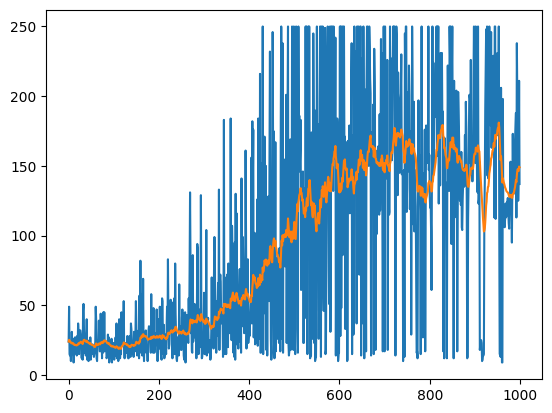

In [78]:
visualize_scores(scores)

In [13]:
test_epochs = 200
test_duration = 500
test_scores = []
for i in (pbar := trange(test_epochs)):

    s, _ = env.reset()

    actions_taken = 0
    total_loss = 0
    while True:
        actions_taken += 1
        a, q = choose_action(q_network, s, 0.0)
        s, r, terminate = take_action(env, a)

        terminate = terminate or \
                    (actions_taken == test_duration)

        if terminate:
            pbar.set_postfix_str(f"actions_taken={actions_taken}", refresh=False)
            test_scores.append(actions_taken)
            break

  0%|          | 0/200 [00:00<?, ?it/s]

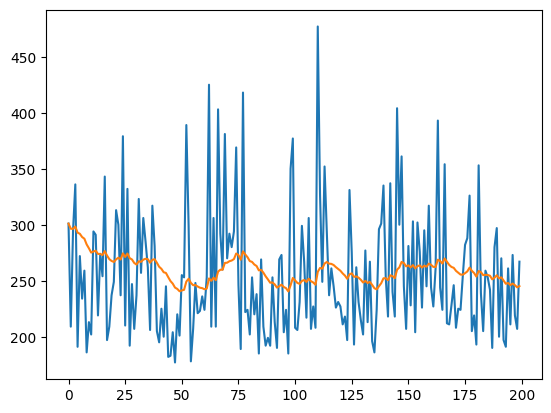

In [14]:
visualize_scores(test_scores)